import library

In [2]:
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Load Dataset

In [3]:
IMAGE_SIZE = 264
IMAGE_SIZE = 264
BATCH_SIZE = 32
Channels = 3
epochs = 10

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [6]:
len(dataset)

102

In [7]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(264, 264, 3)


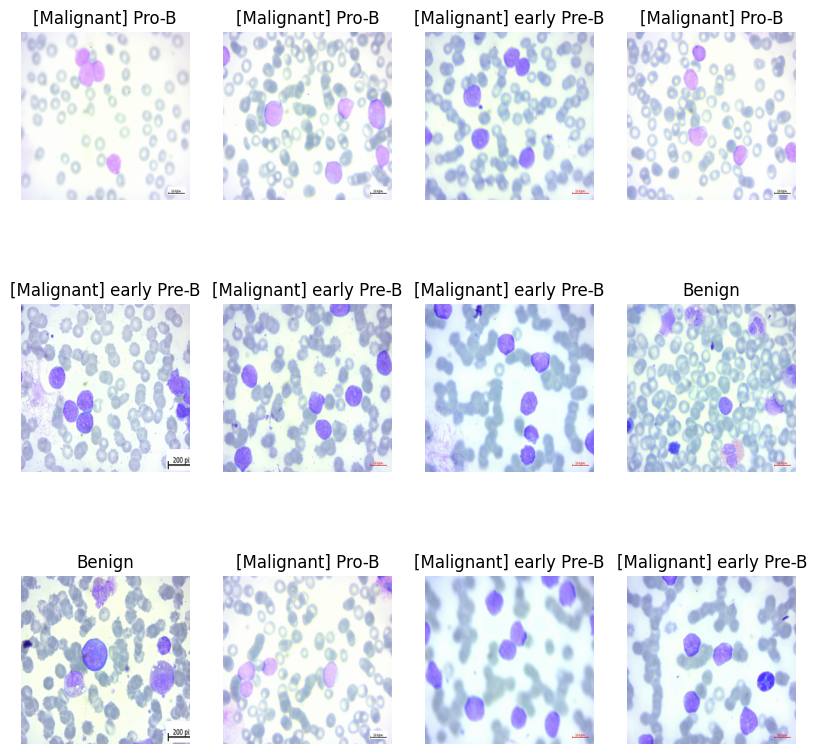

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  
                 
             

Spliting_Dataset

In [9]:
len(dataset)

102

In [10]:
#80% ==> training 
# 20% ==> 10% validation , 10% test

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [12]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)


In [13]:
len(train_ds)


81

In [14]:
len(test_ds)

11

In [15]:
len(val_ds)

10

Data preprocessing

In [16]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = "Blood cell Cancer [ALL]"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor ='val_accuracy',
    mode ='max',
    save_best_only=True,
    verbose=2
  
)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 264, 264, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 264, 264, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 262, 262, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 131, 131, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 129, 129, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                  

In [22]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [23]:
history = model.fit( 
    train_ds, 
    epochs= 10,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1
       )
 

Epoch 1/10
81/81 [==============================] - 98s 1s/step - loss: 3.0308 - accuracy: 0.4611 - val_loss: 0.8931 - val_accuracy: 0.5844
Epoch 2/10
81/81 [==============================] - 72s 886ms/step - loss: 0.6572 - accuracy: 0.7389 - val_loss: 0.5448 - val_accuracy: 0.8094
Epoch 3/10
81/81 [==============================] - 72s 894ms/step - loss: 0.5737 - accuracy: 0.7798 - val_loss: 0.3855 - val_accuracy: 0.8531
Epoch 4/10
81/81 [==============================] - 72s 895ms/step - loss: 0.3850 - accuracy: 0.8482 - val_loss: 0.2857 - val_accuracy: 0.8906
Epoch 5/10
81/81 [==============================] - 72s 893ms/step - loss: 0.3568 - accuracy: 0.8673 - val_loss: 0.3051 - val_accuracy: 0.9062
Epoch 6/10
81/81 [==============================] - 74s 918ms/step - loss: 0.3228 - accuracy: 0.8798 - val_loss: 0.2897 - val_accuracy: 0.8938
Epoch 7/10
81/81 [==============================] - 73s 904ms/step - loss: 0.3525 - accuracy: 0.8658 - val_loss: 0.4058 - val_accuracy: 0.8094
Ep

In [24]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 24s 175ms/step - loss: 0.2497 - accuracy: 0.9062


In [25]:
scores

[0.2497045397758484, 0.90625]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 81}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

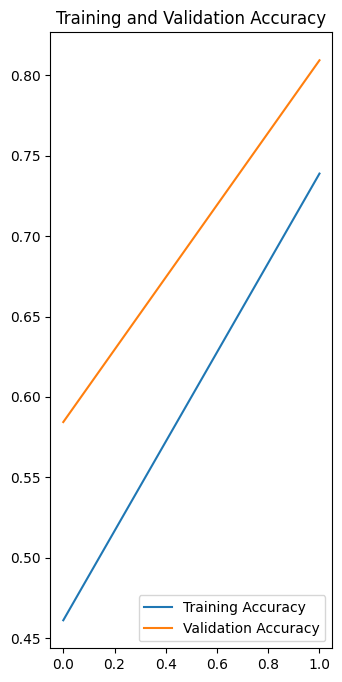

In [30]:

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

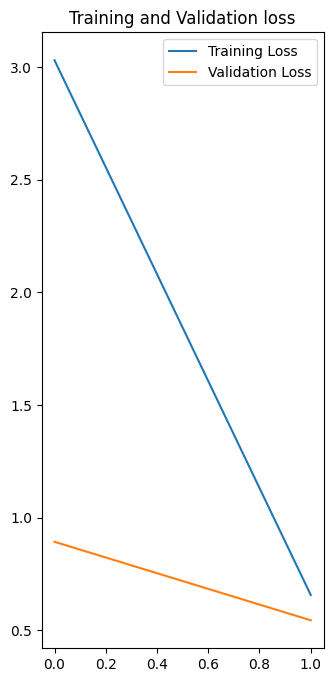

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pro-B
1/1 [==============================] - 0s 285ms/step
predicted label: [Malignant] Pro-B


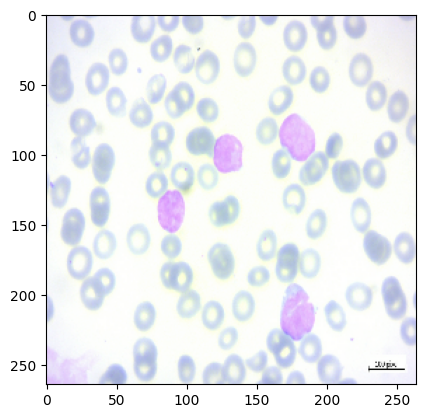

In [32]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


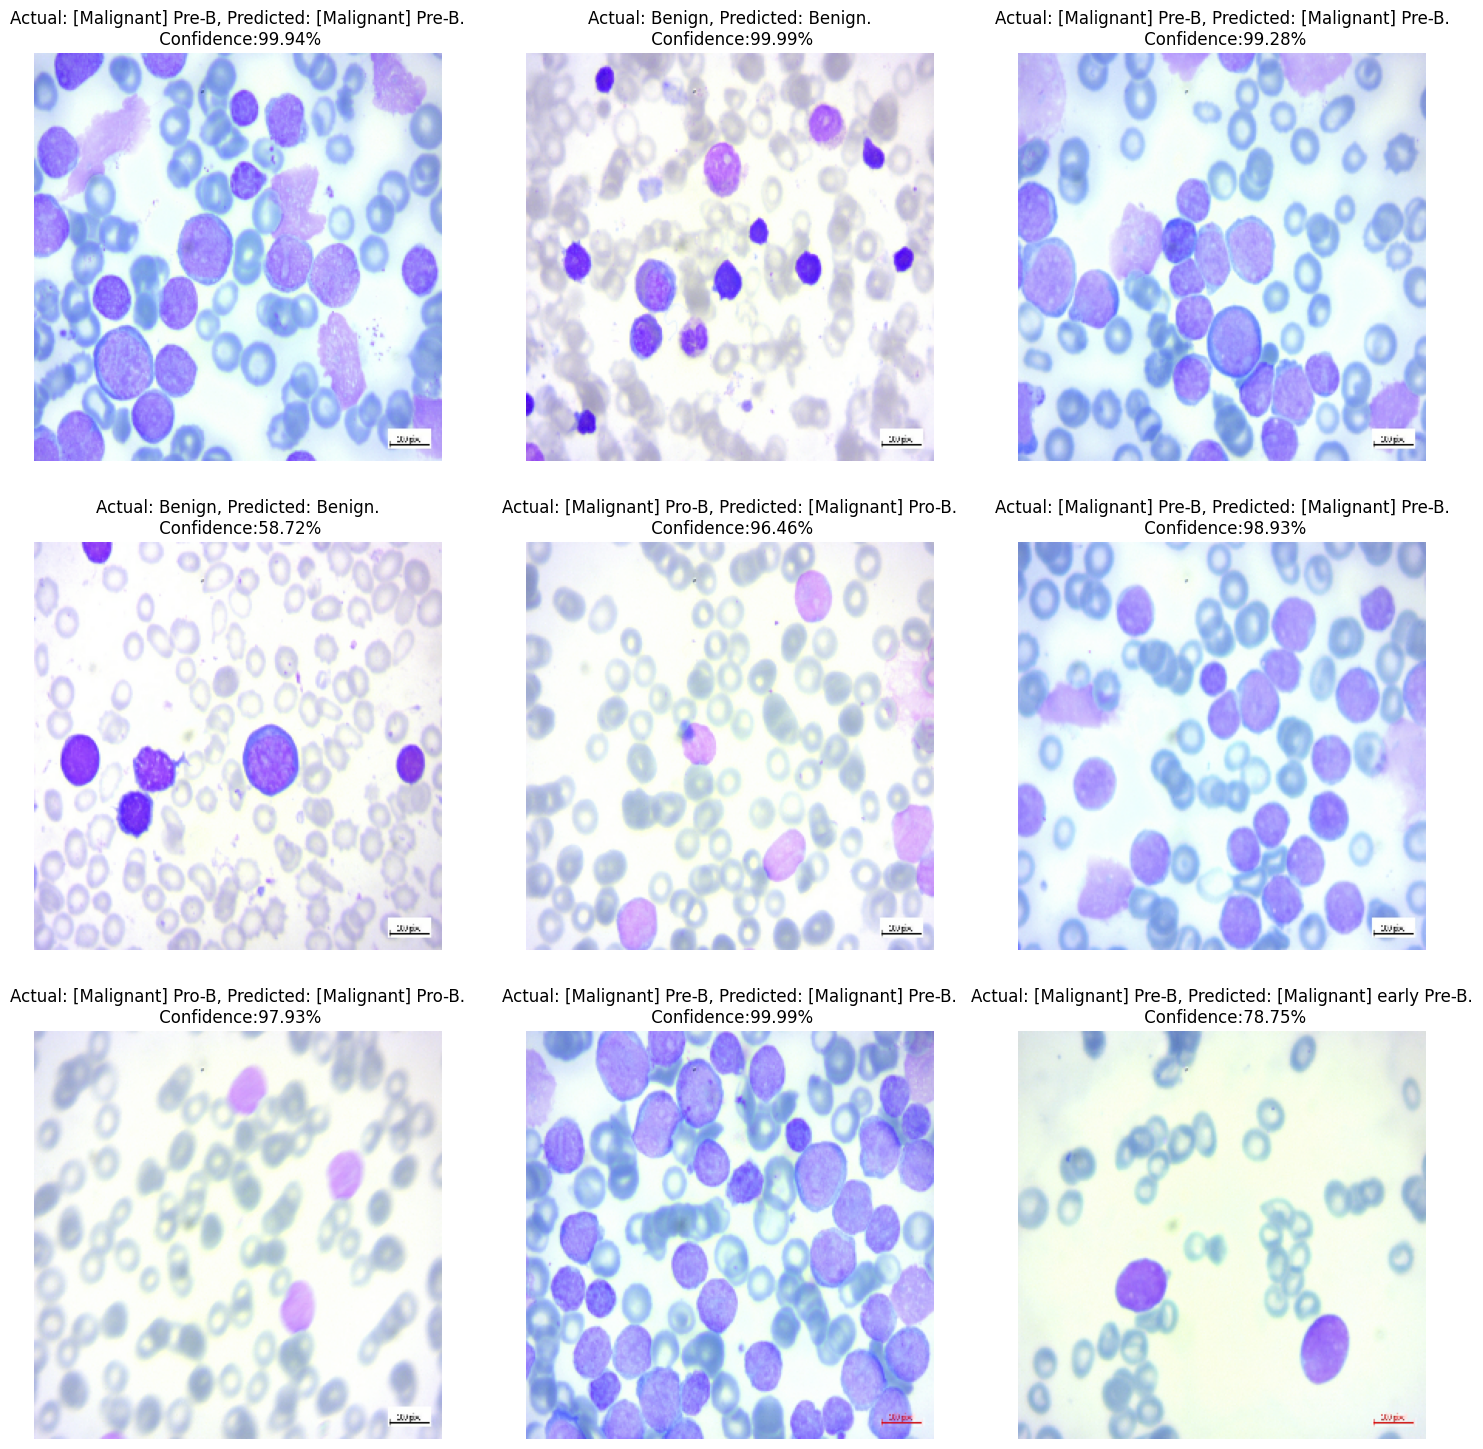

In [34]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [35]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
